# Second population's analysis
**INCLUDE:**
1. Data Exploration
2. Classification Algorithms
3. Regression Algorithms

In [27]:
#Data processing
import numpy as np
import pandas as pd
from sklearn import preprocessing
import plotly.plotly as py
import plotly.figure_factory as ff

#Plotting
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns; sns.reset_orig()

#Analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn import cluster
from sklearn import manifold

#Machine Learning Model
#Common Model Algorithms
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier, RandomTreesEmbedding
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
#For xgboost
import xgboost as xgb

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import random_projection

#Model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


%matplotlib inline

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning:


examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning:


The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.



In [3]:
df = pd.read_csv("/Users/duc_hoang/Box Sync/Fermilab Summer Research/CNN-Architectural-Analysis/MINERvA-Vertex-Finding/Data/Second-population/Second-population-attributes.csv",
                index_col = 0)

In [5]:
df = df.dropna()

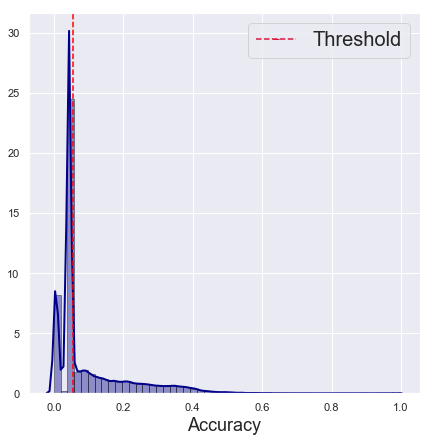

In [18]:
#histogram
fig = plt.figure(figsize=[7,7])
fig1 = sns.distplot(df["final_accuracy"],
                    hist=True, kde=True, 
                    color = 'darkblue',
                    hist_kws={'edgecolor':'black'},
                    kde_kws={'linewidth': 2}, norm_hist=True);

fig1.set_xlabel("Accuracy", fontsize = 18)
plt.axvline(x = 0.055, ls = "--", c = "red")

# Manually add legend
threshold = mlines.Line2D([], [], color='crimson', marker='_', linestyle='--',
                                    markersize=6, label='Threshold', alpha = 1)

plt.legend(handles=[threshold], fontsize = 20)

In [7]:
#Classification models

In [19]:
#Select the features and dependent variable
X = df.drop(columns=['initial_accuracy','final_accuracy', 'genealogy']) #Features
y = pd.Series([0 if x < 0.043451 else 1 for x in df['final_accuracy']]) #dependent variable

In [20]:
#Divide train and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state=0)

In [21]:
#Scale the inputs
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [24]:
#Explore random forest
rf = RandomForestClassifier(n_estimators=150,
                             max_depth=17, bootstrap = False,  min_samples_split=2, 
                             warm_start = True, random_state=0)

rf.fit(X_train, y_train)

print("Accuracy : %f" % rf.score(X_test, y_test))

Accuracy : 0.718537


In [25]:
print("Cross-validation score on train set: ", np.average(cross_val_score(rf, X_train, y_train, cv = 5)))

Cross-validation score on train set:  0.7180529595937817


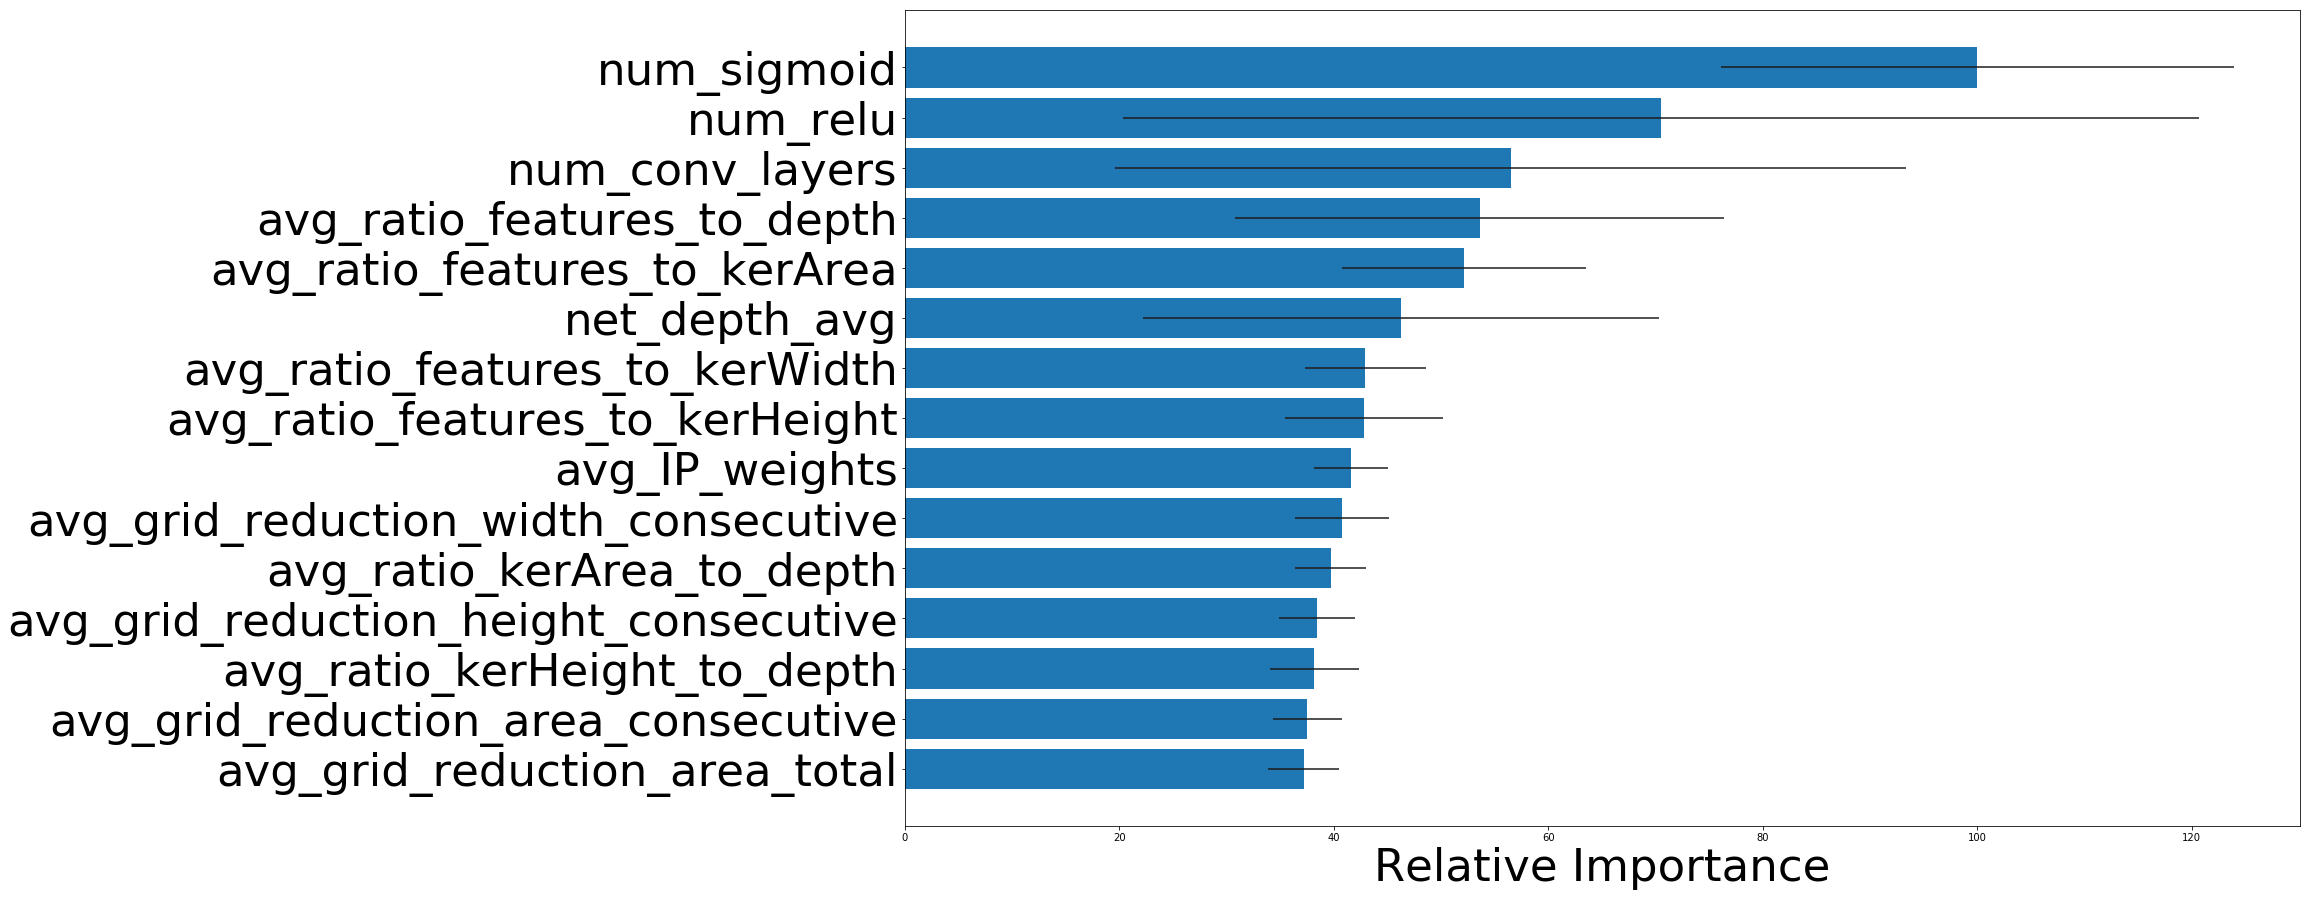

In [28]:
#Feature Importance extraction
feature_importance1 = rf.feature_importances_

# Compute the standard deviation
std1 = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

#scale the std first
std1 = 100.0 * (std1/ feature_importance1.max())

# make importances relative to max importance
feature_importance1 = 100.0 * (feature_importance1 / feature_importance1.max())

features_importance_rf1 = pd.DataFrame({'Feature':X.columns,'Importance':feature_importance1, "Error":std1})

Sorted_Features_importance_rf1 = features_importance_rf1.sort_values(by=['Importance'])

#Just show the first 15 most important features
toShow_15 = Sorted_Features_importance_rf1.iloc[-15:,:]
pos = np.arange(toShow_15.shape[0]) + .5

#Plotting
fig = plt.figure(figsize = [25,15])
plt.barh(pos, toShow_15['Importance'], align='center', xerr = toShow_15['Error'])
plt.yticks(pos, toShow_15['Feature'], fontsize = 45)
plt.xlabel('Relative Importance', fontsize = 45)
plt.show()

In [29]:
ext = ExtraTreesClassifier(n_estimators=100, max_depth=50, 
                           min_samples_split=10, bootstrap = False, 
                            warm_start = True, random_state=0)

ext.fit(X_train, y_train)

print("Accuracy : %f" % ext.score(X_test, y_test))

Accuracy : 0.719245


In [30]:
print("Cross-validation score on train set: ", np.average(cross_val_score(ext, X_train, y_train, cv = 5)))

Cross-validation score on train set:  0.7173001495776573


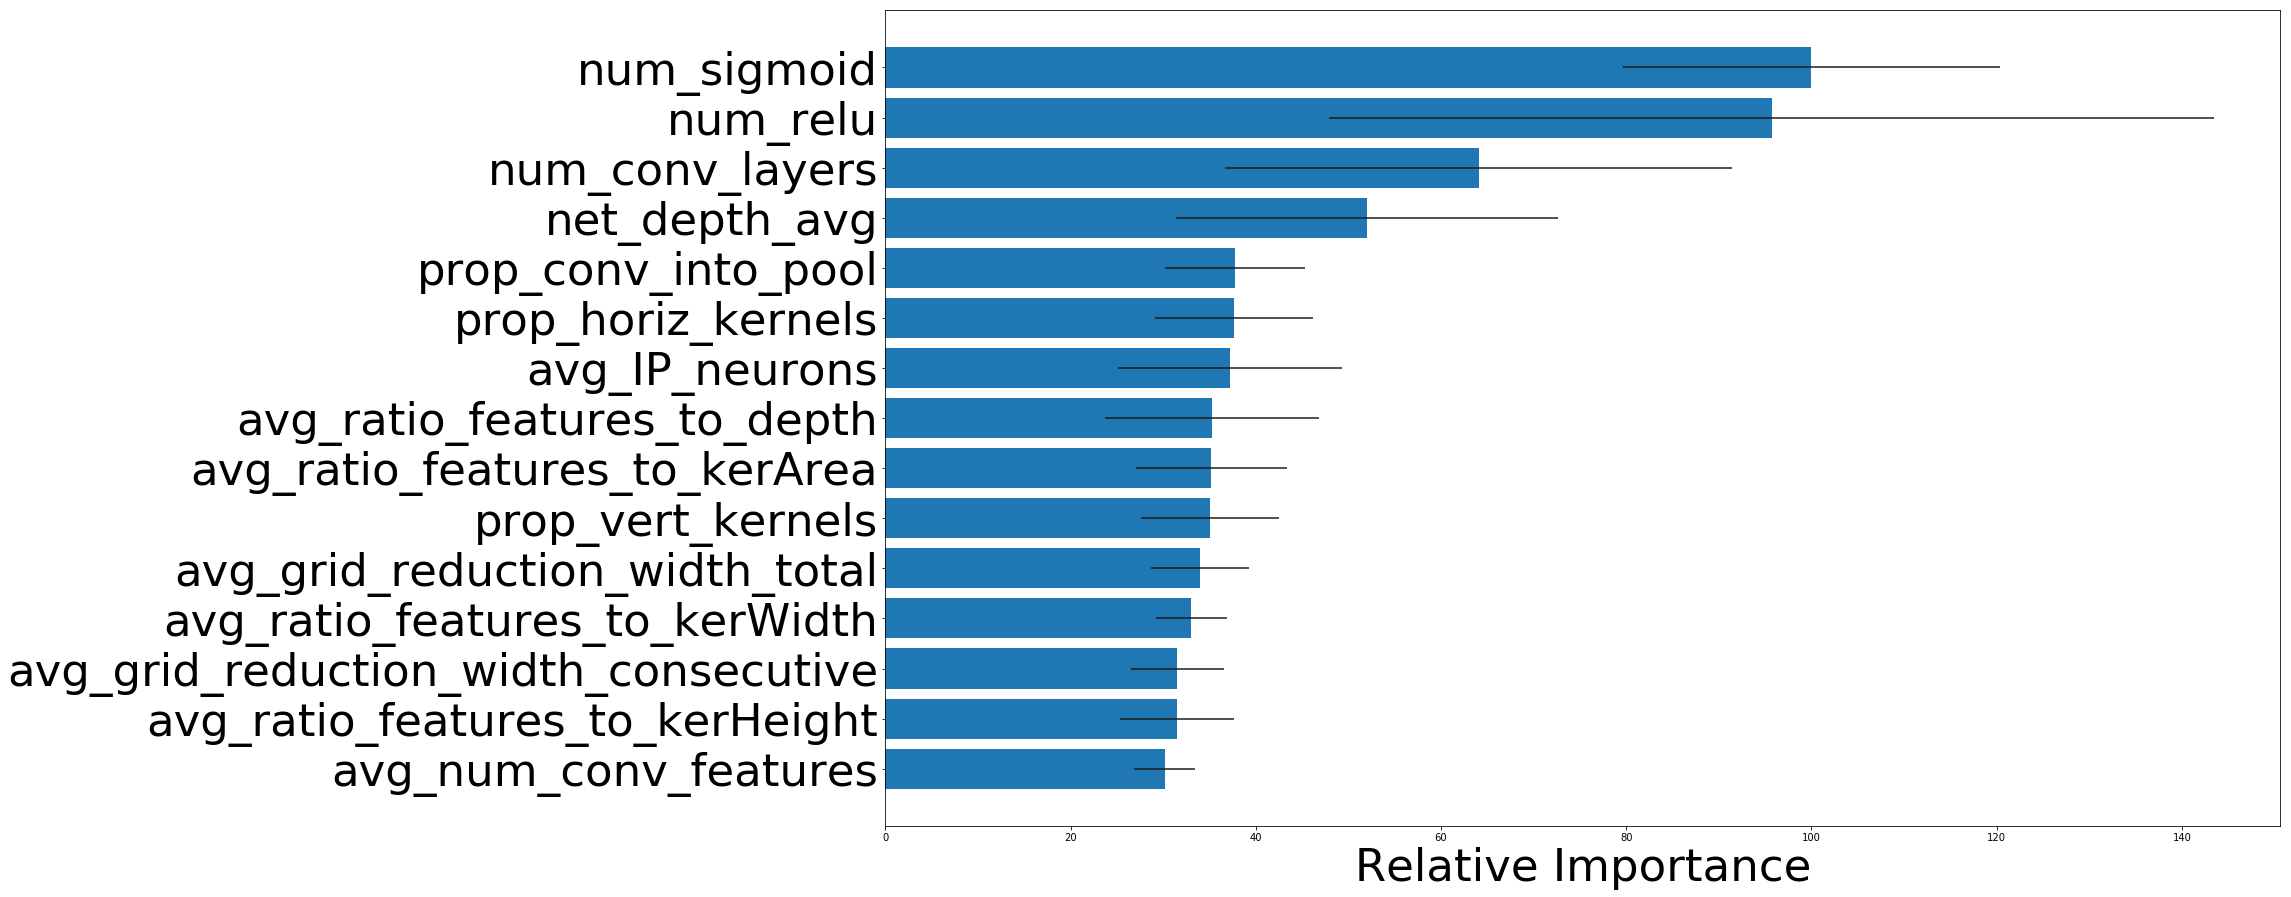

In [31]:
#Feature importance extraction from model
feature_importance11 = ext.feature_importances_

# Compute the standard deviation
std11 = np.std([tree.feature_importances_ for tree in ext.estimators_], axis=0)

#scale the std first
std11 = 100.0 * (std11/ feature_importance11.max())

# make importances relative to max importance
feature_importance11 = 100.0 * (feature_importance11 / feature_importance11.max())

features_importance_rf11 = pd.DataFrame({'Feature':X.columns,'Importance':feature_importance11, "Error":std11})

Sorted_Features_importance_rf11 = features_importance_rf11.sort_values(by=['Importance'])

#Just show the first 15 most important features
toShow_151 = Sorted_Features_importance_rf11.iloc[-15:,:]

pos = np.arange(toShow_151.shape[0]) + .5

fig = plt.figure(figsize = [25,15])
plt.barh(pos, toShow_151['Importance'], align='center', xerr = toShow_151['Error'])
plt.yticks(pos, toShow_151['Feature'], fontsize = 45)
plt.xlabel('Relative Importance', fontsize = 45)
plt.show()

In [32]:
df['group_name'] = ['Broken Networks' if x < 0.043451 else "Healthy Networks" for x in df['final_accuracy']]

Text(0.5, 0, '')

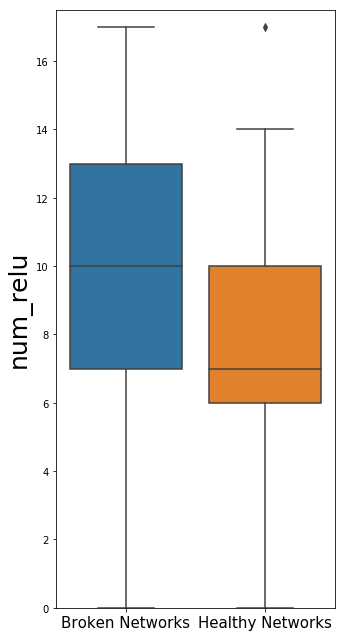

In [33]:
var = 'group_name'
data = pd.concat([df['num_relu'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(5, 11))
fig = sns.boxplot(x=var, y='num_relu', order = ["Broken Networks","Healthy Networks"], data=data)
fig.axis(ymin=0, ymax=17.50);
plt.xticks(fontsize=15);
ax.yaxis.label.set_size(25)
fig.set_xlabel('')

Text(0.5, 0, '')

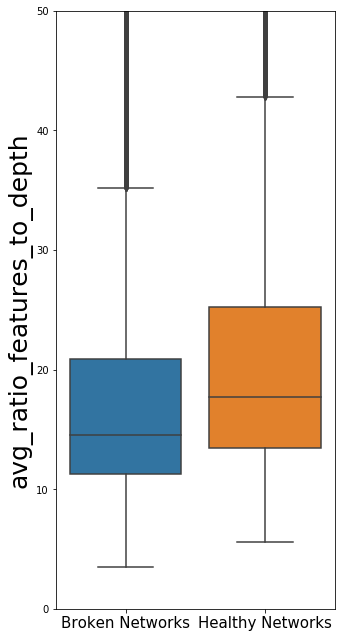

In [34]:
var = 'group_name'
data = pd.concat([df['avg_ratio_features_to_depth'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(5, 11))
fig = sns.boxplot(x=var, y='avg_ratio_features_to_depth', order = ["Broken Networks","Healthy Networks"], data=data)
fig.axis(ymin=0, ymax=50);
plt.xticks(fontsize=15);
ax.yaxis.label.set_size(25)
fig.set_xlabel('')

In [35]:
df['group'] = [0 if x < 0.043451 else 1 for x in df['final_accuracy']]

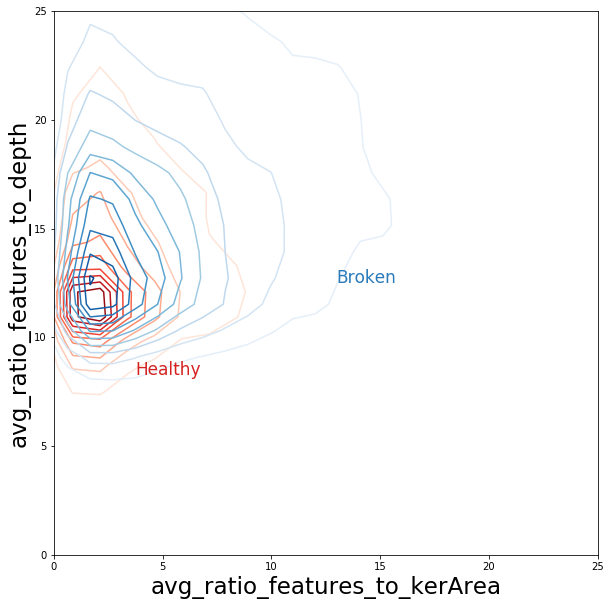

In [37]:
#avg_ratio_features_to_kerArea and avg_ratio_features_to_depth
data1 = df[df['group'] == 0]
data2 = df[df['group'] == 1]
# Set up the figure
f, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(data1['avg_ratio_features_to_kerArea'], data1['avg_ratio_features_to_depth'],
                 cmap="Reds", shade=False, shade_lowest=False)
ax = sns.kdeplot(data2['avg_ratio_features_to_kerArea'], data2['avg_ratio_features_to_depth'],
                 cmap="Blues", shade=False, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(13, 12.5, "Broken", size=17, color=blue)
ax.text(3.75, 8.25, "Healthy", size=17, color=red)
plt.xlim(0,25)
plt.ylim(0,25)
ax.yaxis.label.set_size(23)
ax.xaxis.label.set_size(23)

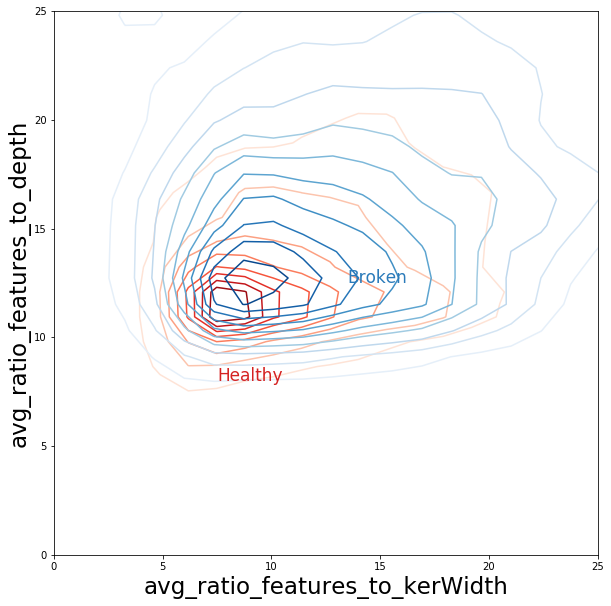

In [38]:
#avg_ratio_features_to_kerWidth and avg_ratio_features_to_depth
# Set up the figure
f, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(data1['avg_ratio_features_to_kerWidth'], data1['avg_ratio_features_to_depth'],
                 cmap="Reds", shade=False, shade_lowest=False)
ax = sns.kdeplot(data2['avg_ratio_features_to_kerWidth'], data2['avg_ratio_features_to_depth'],
                 cmap="Blues", shade=False, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(13.5, 12.5, "Broken", size=17, color=blue)
ax.text(7.5, 8, "Healthy", size=17, color=red)
plt.xlim(0,25)
plt.ylim(0,25)
ax.yaxis.label.set_size(23)
ax.xaxis.label.set_size(23)

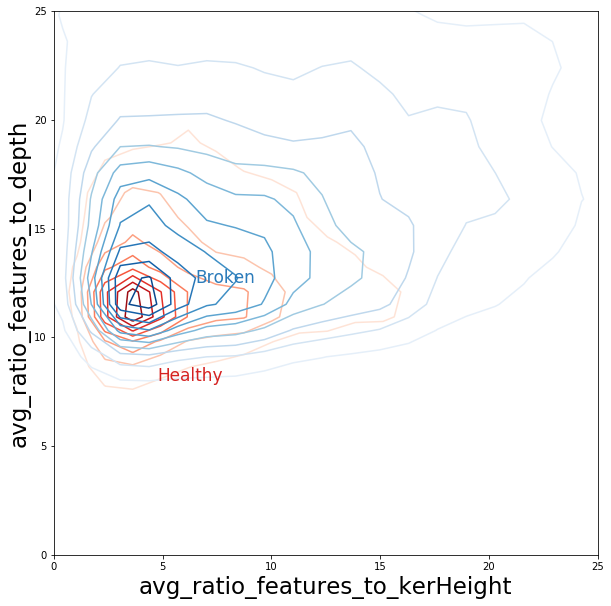

In [39]:
#avg_ratio_features_to_kerHeight and avg_ratio_features_to_depth
# Set up the figure
f, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(data1['avg_ratio_features_to_kerHeight'], data1['avg_ratio_features_to_depth'],
                 cmap="Reds", shade=False, shade_lowest=False)
ax = sns.kdeplot(data2['avg_ratio_features_to_kerHeight'], data2['avg_ratio_features_to_depth'],
                 cmap="Blues", shade=False, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(6.5, 12.5, "Broken", size=17, color=blue)
ax.text(4.75, 8, "Healthy", size=17, color=red)
plt.xlim(0,25)
plt.ylim(0,25)
ax.yaxis.label.set_size(23)
ax.xaxis.label.set_size(23)